# Referencia a la implementación

https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/

In [1]:
!python --version

Python 3.9.22


In [2]:
import os
os.environ["JAVA_HOME"] = "/home/cristhian/Descargas/OpenJDK11U-jdk_x64_linux_hotspot_11.0.27_6/jdk-11.0.27+6"

In [3]:
import numpy as np
from scipy.spatial import distance

In [4]:
import pyspark.sql.functions as sql_f
from pyspark.sql import SparkSession

cores = 12

spark = (
    SparkSession.builder.master(f"local[{cores}]")
    .appName(f"Local DT con {cores} particiones")
    .config("spark.driver.memory", "24g")
    .config("spark.executor.memory", "24g")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

    .getOrCreate()
)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoints")

Ivy Default Cache set to: /home/cristhian/.ivy2/cache
The jars for the packages stored in: /home/cristhian/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-984e4e50-9e45-4341-916d-7fe66c96e9c8;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/cristhian/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 83ms :: artifacts dl 2ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-984e4e50-9e45-4341-916d-7fe66c96e9c8
	confs: [default]
	0 artifacts copied, 2 already retrieved (0kB/3ms)
25/04/23 01:08:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your 

In [5]:
spark.version

'3.2.2'

In [6]:
# Prueba mínima de GraphFrames
from graphframes import GraphFrame

vertices = spark.createDataFrame([("a",), ("b",), ("c",)], ["id"])
edges = spark.createDataFrame([("a", "b"), ("b", "c")], ["src", "dst"])
g = GraphFrame(vertices, edges)

g.connectedComponents().show()

+---+-------------+
| id|    component|
+---+-------------+
|  a|1047972020224|
|  b|1047972020224|
|  c|1047972020224|
+---+-------------+



# Carga de datos

In [7]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


# Lectura del dataset
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('delimiter', ',') \
    .load('spotify_songs.csv') \
    .repartition(12)

# Lista de columnas a convertir
cols_to_convert = [
    "track_popularity", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
    "tempo", "duration_ms"
]

# Castea las columnas especificadas a DoubleType
for c in cols_to_convert:
    df = df.withColumn(c, col(c).cast(DoubleType()))


# Filtrado de géneros incorrectos
valid_genres = ['pop', 'rock', 'rap', 'edm', 'r&b', 'latin']
df = df.filter(col('playlist_genre').isin(valid_genres))
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select(
    'playlist_genre').distinct().count())

cols_to_drop = [
    'track_id', 'track_name', 'track_artist',
    'track_album_id', 'track_album_name',
    'playlist_name', 'playlist_id'
]

df = df.drop(*cols_to_drop).cache()

+--------------+
|playlist_genre|
+--------------+
|           r&b|
|           pop|
|           edm|
|           rap|
|          rock|
|         latin|
+--------------+

Número de géneros únicos: 6


In [8]:
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

categorical_cols = ['playlist_genre']


def one_hot_preprocess(df, categorical_cols):

    indexers = [StringIndexer(inputCol=col, outputCol=col +
                              '_idx', handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(
        inputCol=col + '_idx', outputCol=col + '_ohe') for col in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    return pipeline.fit(df).transform(df)

In [9]:
from pyspark.sql.functions import substring
categorical_cols = ['playlist_genre']
df = one_hot_preprocess(df, categorical_cols=categorical_cols)


# Extraer el año de la fecha (formato 'YYYY-MM-DD')
df = df.withColumn("release_year", substring(
    "track_album_release_date", 1, 4).cast("int"))

df = df.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')

In [10]:
categorical_cols = ['playlist_genre']
idx_cols = [col + '_idx' for col in categorical_cols]
df = df.drop(*idx_cols)

In [11]:
from pyspark.sql.functions import size, col
from pyspark.ml.functions import vector_to_array

# Convertir vectores a arrays
df = df.withColumn("playlist_genre_array",
                   vector_to_array("playlist_genre_ohe"))
# df = df.withColumn("playlist_subgenre_array", vector_to_array("playlist_subgenre_ohe"))

# Obtener tamaños
genre_length = df.select(
    size("playlist_genre_array").alias("size")).first()["size"]
# subgenre_length = df.select(size("playlist_subgenre_array").alias("size")).first()["size"]

# Usar los tamaños directamente en los loops
for i in range(genre_length):
    df = df.withColumn(f"playlist_genre_{i}", col(
        "playlist_genre_array").getItem(i))

# for i in range(subgenre_length):
    # df = df.withColumn(f"playlist_subgenre_{i}", col("playlist_subgenre_array").getItem(i))

In [12]:
# Eliminar las variables redundantes
df = df.drop('playlist_genre_ohe', 'playlist_genre_array')

In [13]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df = assembler.transform(df)

# Volver el vector a Dense Vector
# df = df.withColumn("features_intermedio", vector_to_array("features")

scaler = StandardScaler(
    inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

df.show(10, truncate=False)

25/04/23 01:08:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|release_year|playlist_genre_0|playlist_genre_1|playlist_genre_2|playlist_genre_3|playlist_genre_4|

In [14]:
# Insertar aqui arriba notebook de preprocesado

In [15]:
from pyspark.ml.feature import PCA

pca = PCA(k=len(df.columns) - 2, inputCol="scaled_features",
          outputCol="pca_features")
pca_model = pca.fit(df)

25/04/23 01:08:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/23 01:08:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
25/04/23 01:08:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/23 01:08:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [16]:
# Aplicamos pca

pca_data = pca_model.transform(df).cache()

In [17]:
# 1. Convertir Vector -> Array[Double]
df2 = pca_data.withColumn("pca_array", vector_to_array("pca_features"))

# 2. Saber cuántas componentes hay (ej.: k)
#    O bien lo hardcodeas si lo conoces de antemano.
k = 14  # len(df2.select("pca_array").first()[0])

# 3. Seleccionar todas las columnas que quieras y expandir el array
cols_originales = [c for c in df2.columns if c not in (
    "pca_array", "pca_features")]
df_pca = df2.select(
    *[col("pca_array")[i].alias(f"pc_{i+1}") for i in range(k)]
)

df_pca.printSchema()

root
 |-- pc_1: double (nullable = true)
 |-- pc_2: double (nullable = true)
 |-- pc_3: double (nullable = true)
 |-- pc_4: double (nullable = true)
 |-- pc_5: double (nullable = true)
 |-- pc_6: double (nullable = true)
 |-- pc_7: double (nullable = true)
 |-- pc_8: double (nullable = true)
 |-- pc_9: double (nullable = true)
 |-- pc_10: double (nullable = true)
 |-- pc_11: double (nullable = true)
 |-- pc_12: double (nullable = true)
 |-- pc_13: double (nullable = true)
 |-- pc_14: double (nullable = true)



In [18]:
df_pca.show(1)

+-------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+-----------------+-------------------+-----------------+------------------+-----------------+------------------+--------------------+
|               pc_1|              pc_2|                pc_3|              pc_4|              pc_5|               pc_6|              pc_7|             pc_8|               pc_9|            pc_10|             pc_11|            pc_12|             pc_13|               pc_14|
+-------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+-----------------+-------------------+-----------------+------------------+-----------------+------------------+--------------------+
|-0.4970137739930596|2.6596176960991893|-0.38417093108842293|-1.393663788042694|0.9432916386462085|-0.3449971333831926|0.8476041109303813|-0.62702095361051|-0.3597532362271783|1.147029

In [19]:
# Muestreamos el dataset
df_sampled = df_pca.sample(withReplacement=False, fraction=0.5, seed=123456)

In [20]:
df_sampled.show(10)

+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|                pc_1|                pc_2|               pc_3|               pc_4|                pc_5|               pc_6|                pc_7|                pc_8|                pc_9|               pc_10|               pc_11|               pc_12|              pc_13|               pc_14|
+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|  1.6615186744633699|  -0.102576784425906|0.31433482170705407| 0.3683784171736583| -1.0206589025161692| 0.7826920914496924|

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id


# 1. Añadir una columna 'id' (si no la tienes)
df = df_sampled.withColumn("id", monotonically_increasing_id())

# 2. Crear el assembler para juntar todas las columnas pc_1, pc_2, ..., pc_14
input_cols = [f"pc_{i}" for i in range(1, 15)]  # pc_1 hasta pc_14
assembler = VectorAssembler(inputCols=input_cols, outputCol="value")

# 3. Aplicar el assembler
df_vectorized = assembler.transform(df)

# 4. Seleccionar solo 'id' y 'value'
result = df_vectorized.select("id", "value")

# Mostrar el resultado
result.show(truncate=False)

+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |value                                                                                                                                                                                                                                                                                       |
+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |[1.6615186744633699,-0.102576784425906,0.31433482170705407,0.3683784171736583,-1.0206589025161692,0.7826920914496924,-0.36

# Código de DBScan original

In [22]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = df.rdd.takeSample(False, 1)[0].value

    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()

    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item)
                    for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None


__all__ = [process]

# Código de DBScan con comentarios (debug)

In [23]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=pivot_dist)]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        out = {}
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        result = [Row(id=item[0], neighbors=item[1]) for item in out.items()]
        return result
    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            cluster_label = x[0]
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                out.append((idx, [(cluster_label, False)]))
            return out
        return []
    return label


def __combine_labels(x):
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type:
            core_point = True
        clusters.append(label)
    return point, clusters if core_point else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    zero = df.rdd.takeSample(False, 1)[0].value
    print(">> rdd sample:", df.rdd.take(5))
    print(">> Zero (pivot sample):", zero)

    rdd_1 = df.rdd.flatMap(__distance_from_pivot(
        zero, dist, epsilon, operations))
    print(">> rdd_1 sample:")
    print(rdd_1.take(10))
    print("FIN")

    print('Null count', rdd_1.filter(col("value").isNull()).count())

    rdd_2 = rdd_1.reduceByKey(lambda x, y: x + y)
    print(">> rdd_2 sample:", rdd_2.take(1))

    rdd_3 = rdd_2.flatMap(__scan(epsilon, dist, operations))
    print(">> rdd_3 sample (neighbors):", rdd_3.take(5))

    rdd_4 = rdd_3.map(lambda x: (x.id, x.neighbors)
                      ).reduceByKey(lambda x, y: x.union(y))
    print(">> rdd_4 sample (merged neighbors):", rdd_4.take(5))

    rdd_5 = rdd_4.flatMap(__label(min_pts))
    print(">> rdd_5 sample (labeled):", rdd_5.take(5))

    rdd_6 = rdd_5.reduceByKey(lambda x, y: x + y)
    print(">> rdd_6 sample (labels grouped):", rdd_6.take(5))

    combine_cluster_rdd = rdd_6.map(__combine_labels).cache()
    print(">> combine_cluster_rdd sample (combined):",
          combine_cluster_rdd.take(5))

    id_cluster_rdd = combine_cluster_rdd.map(lambda x: Row(
        point=x[0], cluster_label=x[1][0], core_point=x[2]))
    print(">> id_cluster_rdd sample:", id_cluster_rdd.take(5))

    try:
        id_cluster_df = id_cluster_rdd.toDF()
        print(">> id_cluster_df schema:")
        id_cluster_df.printSchema()

        vertices = combine_cluster_rdd.flatMap(
            lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
        print(">> vertices preview:")
        vertices.show(5)

        edges = combine_cluster_rdd.flatMap(
            lambda x: [Row(src=item[0], dst=item[1])
                       for item in combinations(x[1], 2)]
        ).toDF().distinct()
        print(">> edges preview:")
        edges.show(5)

        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()

        print(">> connected_df schema:")
        connected_df.printSchema()

        id_cluster_df = id_cluster_df.join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")

        print(">> Final result:")
        id_cluster_df.show(5)

        return id_cluster_df
    except ValueError as e:
        print(">> Error en conversión a DF o GraphFrame:", e)
        return None

In [24]:
df_numeric = result

In [25]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# Definir una función para convertir DenseVector -> list


def vector_to_array(v):
    return v.toArray().tolist()


# Registrar como UDF
vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))

# Aplicarlo
df_final = df_numeric.withColumn("value", vector_to_array_udf("value"))

# Mostrar
df_final.show(truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |value                                                                                                                                                                                                                                                                                                    |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |[1.6615186744633699, -0.102576784425906, 0.31433482170705407, 0.3683784171736583, -

In [26]:
import dbscan
from sklearn.datasets import make_blobs
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
import os
# os.environ["JAVA_HOME"] = "/home/cristhian/Descargas/OpenJDK11U-jdk_x64_linux_hotspot_11.0.27_6/jdk-11.0.27+6"

# df_clusters = dbscan.process(spark, df, .2, 10, distance.euclidean, 2, "checkpoint")

In [27]:
# Ejecución del algoritmo
df_clusters = dbscan.process(
    spark, df_final, 2, 20, distance.euclidean, 14, "checkpoint")

In [28]:
np.unique(np.array(df_clusters.toPandas()["component"]), return_counts=True)

(array([  1,   4,   7,  23,  31, 113, 123, 711, 714, 717, 722]),
 array([2549,  875, 1400,  935, 1101,  449, 1257, 1411, 1067, 1108, 1254]))

In [29]:
np.sum(np.unique(np.array(df_clusters.toPandas()["component"]), return_counts=True)[1])

13406

In [30]:
df_joined = df_final.join(df_clusters, df_final.id == df_clusters.point)
df_joined

DataFrame[id: bigint, value: array<double>, point: bigint, component: bigint, core_point: boolean]

In [31]:
df_results = df_joined.select("id", "value", "component").toPandas()
df_results

,id,value,component
0,8589934869,"[-0.12620417246180451, 1.360676021565607, -0.9...",31
1,77309411946,"[-0.33773326393309594, 2.052968709689877, 0.50...",31
2,60129542250,"[-0.19357134350576108, 1.107613336855758, -0.4...",31
3,85899346577,"[-1.6680382406662124, 1.9999961915763156, 1.02...",31
4,17179869688,"[-1.2876137650671042, 1.257119854782126, 0.886...",31
...,...,...,...
13401,17179869706,"[-1.7636550557750401, 1.446101960278849, 0.902...",31
13402,34359738437,"[-1.2067648952929768, 1.363034439045058, 1.221...",31
13403,77309411765,"[-1.2067648952929768, 1.363034439045058, 1.221...",31
13404,77309411465,"[-1.85900364316635, 0.8608687355580473, 0.9606...",31


In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = np.array(df_results['value'].tolist())

# Crear un modelo PCA para reducir a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear un modelo TSNE para reducir a 2 componentes
tsne = TSNE(n_components=2, random_state=123456, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

# Agregar las componentes principales al DataFrame de Pandas
df_results['pca1'] = X_pca[:, 0]
df_results['pca2'] = X_pca[:, 1]
df_results['tsne1'] = X_tsne[:, 0]
df_results['tsne2'] = X_tsne[:, 1]

In [33]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_result(dataset, result_tags, file_name=None, style='ticks'):

    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags

    # sns preparation
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # Plot raw points (without labels)
    sns.scatterplot(x='x', y='y', data=df, ax=axes[0], color='blue')
    axes[0].set_title('Puntos sin etiquetar')

    # Plot clustered points
    sns.scatterplot(x='x', y='y', data=df, hue='label',
                    ax=axes[1], palette='tab20')
    axes[1].set_title('Resultado del clustering')

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    if file_name:
        f.suptitle(f'DBSCAN Result of {file_name}', fontsize=14)

    plt.tight_layout()
    plt.show()

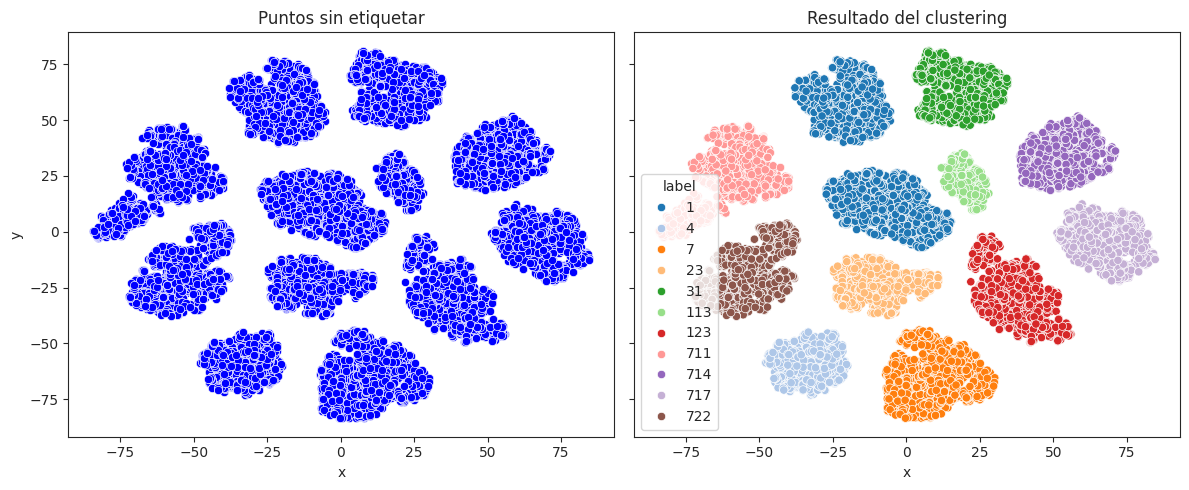

In [34]:
plot_result(X_tsne, df_results["component"])

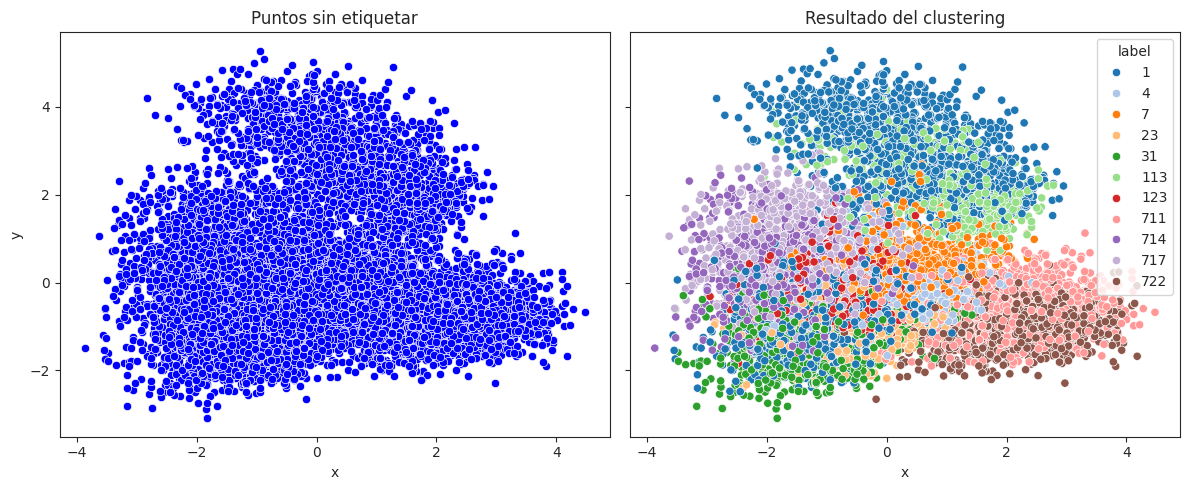

In [35]:
plot_result(X_pca, df_results["component"])